In [19]:
# Install required packages
!pip install nltk transformers torch pandas numpy matplotlib seaborn scikit-learn

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, SpatialDropout1D
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ishitagupta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ishitagupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ishitagupta/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [33]:
# Read datasets
emotions_df = pd.read_csv('/Users/ishitagupta/Library/CloudStorage/OneDrive-Personal/[02] BITS Pilani M Tech Software Systems/[04] Semester 4/[02] SSZG628 - Dissertation/Code Execution/Dataset/Emotions/emotions.csv')
amazon_df = pd.read_csv('/Users/ishitagupta/Library/CloudStorage/OneDrive-Personal/[02] BITS Pilani M Tech Software Systems/[04] Semester 4/[02] SSZG628 - Dissertation/Code Execution/Dataset/Sentiment Analysis labelled/amazon_reviews_with_emotions.csv')

print("Emotions dataset shape:", emotions_df.shape)
print("Amazon reviews dataset shape:", amazon_df.shape)

Emotions dataset shape: (416809, 2)
Amazon reviews dataset shape: (4915, 13)


In [34]:
# Display first few rows of each dataset
print("\nEmotions dataset - first few rows:")
print(emotions_df.head())

print("\nAmazon reviews dataset - first few rows:")
print(amazon_df.head())

# Check for missing values
print("\nMissing values in emotions dataset:")
print(emotions_df.isnull().sum())

print("\nMissing values in amazon dataset:")
print(amazon_df.isnull().sum())


Emotions dataset - first few rows:
                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4

Amazon reviews dataset - first few rows:
   Unnamed: 0  reviewerName  overall  \
0           0           NaN      4.0   
1           1          0mie      5.0   
2           2           1K3      4.0   
3           3           1m2      5.0   
4           4  2&amp;1/2Men      5.0   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  2014-07-23       138   
1  Purchased this for my device, it worked as adv...  2013-10-25       409   
2  it works as expected. I should have sprung for...  2012-12-23       715   
3  This t

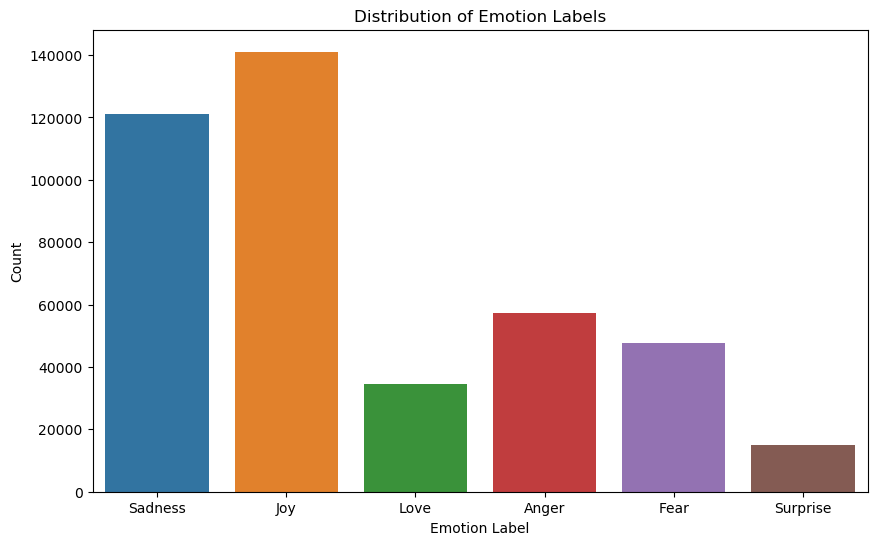

In [35]:
# For this comparative study, we'll focus on the emotions dataset
# Distribution of emotion labels
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=emotions_df)
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3, 4, 5], ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'])
plt.show()

In [36]:
# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [37]:
# Apply preprocessing to text columns
emotions_df['processed_text'] = emotions_df['text'].apply(preprocess_text)
amazon_df['processed_text'] = amazon_df['reviewText'].apply(preprocess_text)

print("\nEmotions dataset after preprocessing - first few rows:")
print(emotions_df[['text', 'processed_text', 'label']].head())


Emotions dataset after preprocessing - first few rows:
                                                text  \
0      i just feel really helpless and heavy hearted   
1  ive enjoyed being able to slouch about relax a...   
2  i gave up my internship with the dmrg and am f...   
3                         i dont know i feel so lost   
4  i am a kindergarten teacher and i am thoroughl...   

                                      processed_text  label  
0                 feel really helpless heavy hearted      4  
1  ive enjoyed able slouch relax unwind frankly n...      0  
2            gave internship dmrg feeling distraught      4  
3                                dont know feel lost      0  
4  kindergarten teacher thoroughly weary job take...      4  


In [38]:
# For emotions dataset
X_emotions = emotions_df['processed_text']
y_emotions = emotions_df['label']

# Split into train and test sets
X_train_emotions, X_test_emotions, y_train_emotions, y_test_emotions = train_test_split(
    X_emotions, y_emotions, test_size=0.2, random_state=42, stratify=y_emotions
)

print(f"\nTraining set size: {len(X_train_emotions)}")
print(f"Testing set size: {len(X_test_emotions)}")


Training set size: 333447
Testing set size: 83362


In [39]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_emotions)
X_test_tfidf = tfidf_vectorizer.transform(X_test_emotions)

In [40]:
# Function to evaluate classical ML models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {accuracy:.4f}")
    
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'],
                yticklabels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return accuracy


Logistic Regression Accuracy: 0.9001

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     24238
           1       0.92      0.93      0.93     28214
           2       0.81      0.77      0.79      6911
           3       0.90      0.90      0.90     11463
           4       0.85      0.85      0.85      9542
           5       0.77      0.71      0.74      2994

    accuracy                           0.90     83362
   macro avg       0.86      0.85      0.86     83362
weighted avg       0.90      0.90      0.90     83362



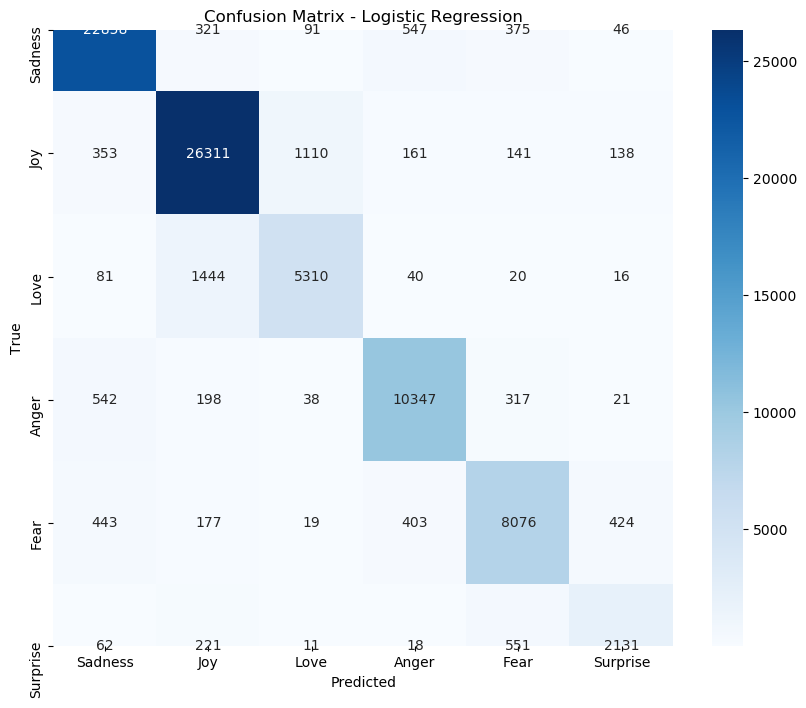

In [14]:
# 1. Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_accuracy = evaluate_model(lr_model, X_train_tfidf, X_test_tfidf, y_train_emotions, y_test_emotions, "Logistic Regression")


Naive Bayes Accuracy: 0.8499

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     24238
           1       0.80      0.97      0.88     28214
           2       0.95      0.49      0.64      6911
           3       0.93      0.79      0.86     11463
           4       0.89      0.73      0.80      9542
           5       0.95      0.31      0.47      2994

    accuracy                           0.85     83362
   macro avg       0.90      0.71      0.76     83362
weighted avg       0.86      0.85      0.84     83362



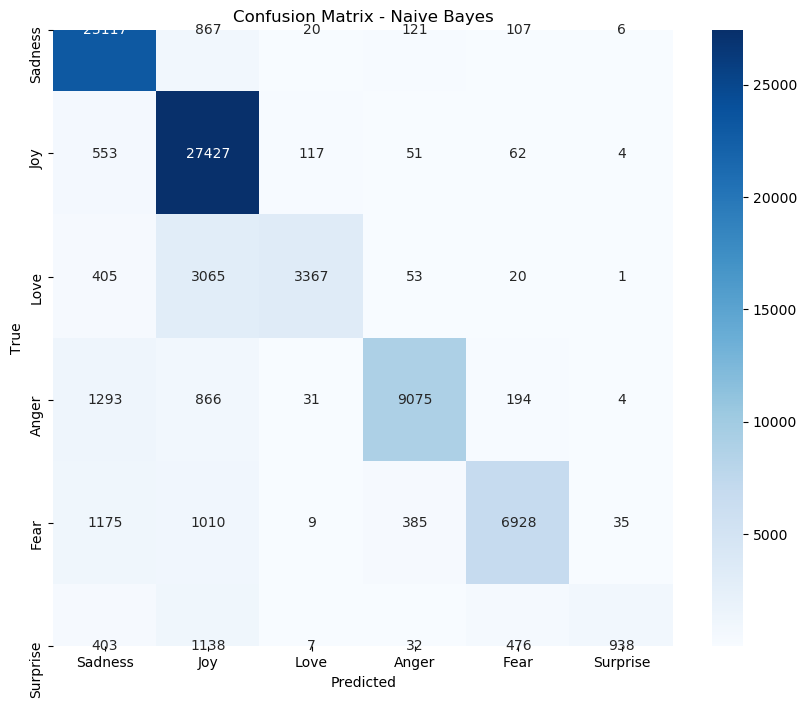

In [15]:
# 3. Naive Bayes
nb_model = MultinomialNB()
nb_accuracy = evaluate_model(nb_model, X_train_tfidf, X_test_tfidf, y_train_emotions, y_test_emotions, "Naive Bayes")

In [16]:
# Tokenize and pad sequences for deep learning models
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_emotions)

X_train_seq = tokenizer.texts_to_sequences(X_train_emotions)
X_test_seq = tokenizer.texts_to_sequences(X_test_emotions)

# Calculate the maximum sequence length
max_len = max([len(x) for x in X_train_seq])
print(f"Maximum sequence length: {max_len}")

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Convert labels to numpy arrays
y_train_np = np.array(y_train_emotions)
y_test_np = np.array(y_test_emotions)

Maximum sequence length: 78


In [45]:
# Add timing functionality to the classical ML evaluation function
import time

def evaluate_model_with_timing(model, X_train, X_test, y_train, y_test, model_name):
    # Training time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Inference time
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Training Time: {train_time:.2f} seconds")
    print(f"{model_name} Inference Time: {inference_time:.2f} seconds")
    
    return accuracy, train_time, inference_time

In [46]:
# Run classical models with timing
# 1. Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_results = evaluate_model_with_timing(lr_model, X_train_tfidf, X_test_tfidf, y_train_emotions, y_test_emotions, "Logistic Regression")

# 2. Naive Bayes
nb_model = MultinomialNB()
nb_results = evaluate_model_with_timing(nb_model, X_train_tfidf, X_test_tfidf, y_train_emotions, y_test_emotions, "Naive Bayes")


Logistic Regression Accuracy: 0.9001
Logistic Regression Training Time: 19.63 seconds
Logistic Regression Inference Time: 0.01 seconds

Naive Bayes Accuracy: 0.8499
Naive Bayes Training Time: 0.05 seconds
Naive Bayes Inference Time: 0.00 seconds


In [47]:
# Modified DL evaluation function with fewer epochs and simpler models
def evaluate_dl_model_with_timing(model, X_train, X_test, y_train, y_test, model_name, epochs=3, batch_size=64):
    # Convert labels to categorical for multi-class classification
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=6)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=6)
    
    # Train the model and measure training time
    start_time = time.time()
    history = model.fit(
        X_train, y_train_cat,
        epochs=epochs,  # Reduced epochs for faster training
        batch_size=batch_size,  # Larger batch size for faster training
        validation_split=0.1,  # Use a small validation split
        verbose=0  # Reduce output for faster execution
    )
    train_time = time.time() - start_time
    
    # Measure inference time
    start_time = time.time()
    y_pred_prob = model.predict(X_test, verbose=0)
    inference_time = time.time() - start_time
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"\n{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"{model_name} Training Time: {train_time:.2f} seconds")
    print(f"{model_name} Inference Time: {inference_time:.2f} seconds")
    
    return accuracy, train_time, inference_time

In [54]:
# Smaller, simplified deep learning models
# Use a smaller embedding dimension and fewer units to speed up training
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50  # Reduced from 100

# 3. LSTM Model - simplified
lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    LSTM(32),  # Reduced units
    Dense(6, activation='softmax')
])
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_results = evaluate_dl_model_with_timing(lstm_model, X_train_pad, X_test_pad, y_train_np, y_test_np, "LSTM", epochs=3)

# 4. Bi-LSTM Model - simplified
bilstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(32)),  # Reduced units
    Dense(6, activation='softmax')
])
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_results = evaluate_dl_model_with_timing(bilstm_model, X_train_pad, X_test_pad, y_train_np, y_test_np, "Bi-LSTM", epochs=3)

# 5. GRU Model - simplified
gru_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    GRU(32),  # Reduced units
    Dense(6, activation='softmax')
])
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_results = evaluate_dl_model_with_timing(gru_model, X_train_pad, X_test_pad, y_train_np, y_test_np, "GRU", epochs=3)


LSTM Test Accuracy: 0.3385
LSTM Training Time: 285.09 seconds
LSTM Inference Time: 6.89 seconds

Bi-LSTM Test Accuracy: 0.9299
Bi-LSTM Training Time: 326.43 seconds
Bi-LSTM Inference Time: 8.71 seconds

GRU Test Accuracy: 0.3385
GRU Training Time: 256.11 seconds
GRU Inference Time: 6.08 seconds


In [55]:
# Collect results
model_names = ['Logistic Regression', 'Naive Bayes', 'LSTM', 'Bi-LSTM', 'GRU']
accuracies = [lr_results[0], nb_results[0], lstm_results[0], bilstm_results[0], gru_results[0]]
training_times = [lr_results[1], nb_results[1], lstm_results[1], bilstm_results[1], gru_results[1]]
inference_times = [lr_results[2], nb_results[2], lstm_results[2], bilstm_results[2], gru_results[2]]

# Create a DataFrame for better visualization
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Training Time (s)': training_times,
    'Inference Time (s)': inference_times
})

# Add model type column for better visualization
comparison_df['Model Type'] = ['Classical ML', 'Classical ML', 'Deep Learning', 'Deep Learning', 'Deep Learning']

print("Model Comparison Results:")
print(comparison_df)

Model Comparison Results:
                 Model  Accuracy  Training Time (s)  Inference Time (s)  \
0  Logistic Regression  0.900086          19.631386            0.006636   
1          Naive Bayes  0.849932           0.048394            0.004788   
2                 LSTM  0.338452         285.088539            6.891087   
3              Bi-LSTM  0.929896         326.432151            8.706280   
4                  GRU  0.338452         256.108471            6.077303   

      Model Type  
0   Classical ML  
1   Classical ML  
2  Deep Learning  
3  Deep Learning  
4  Deep Learning  


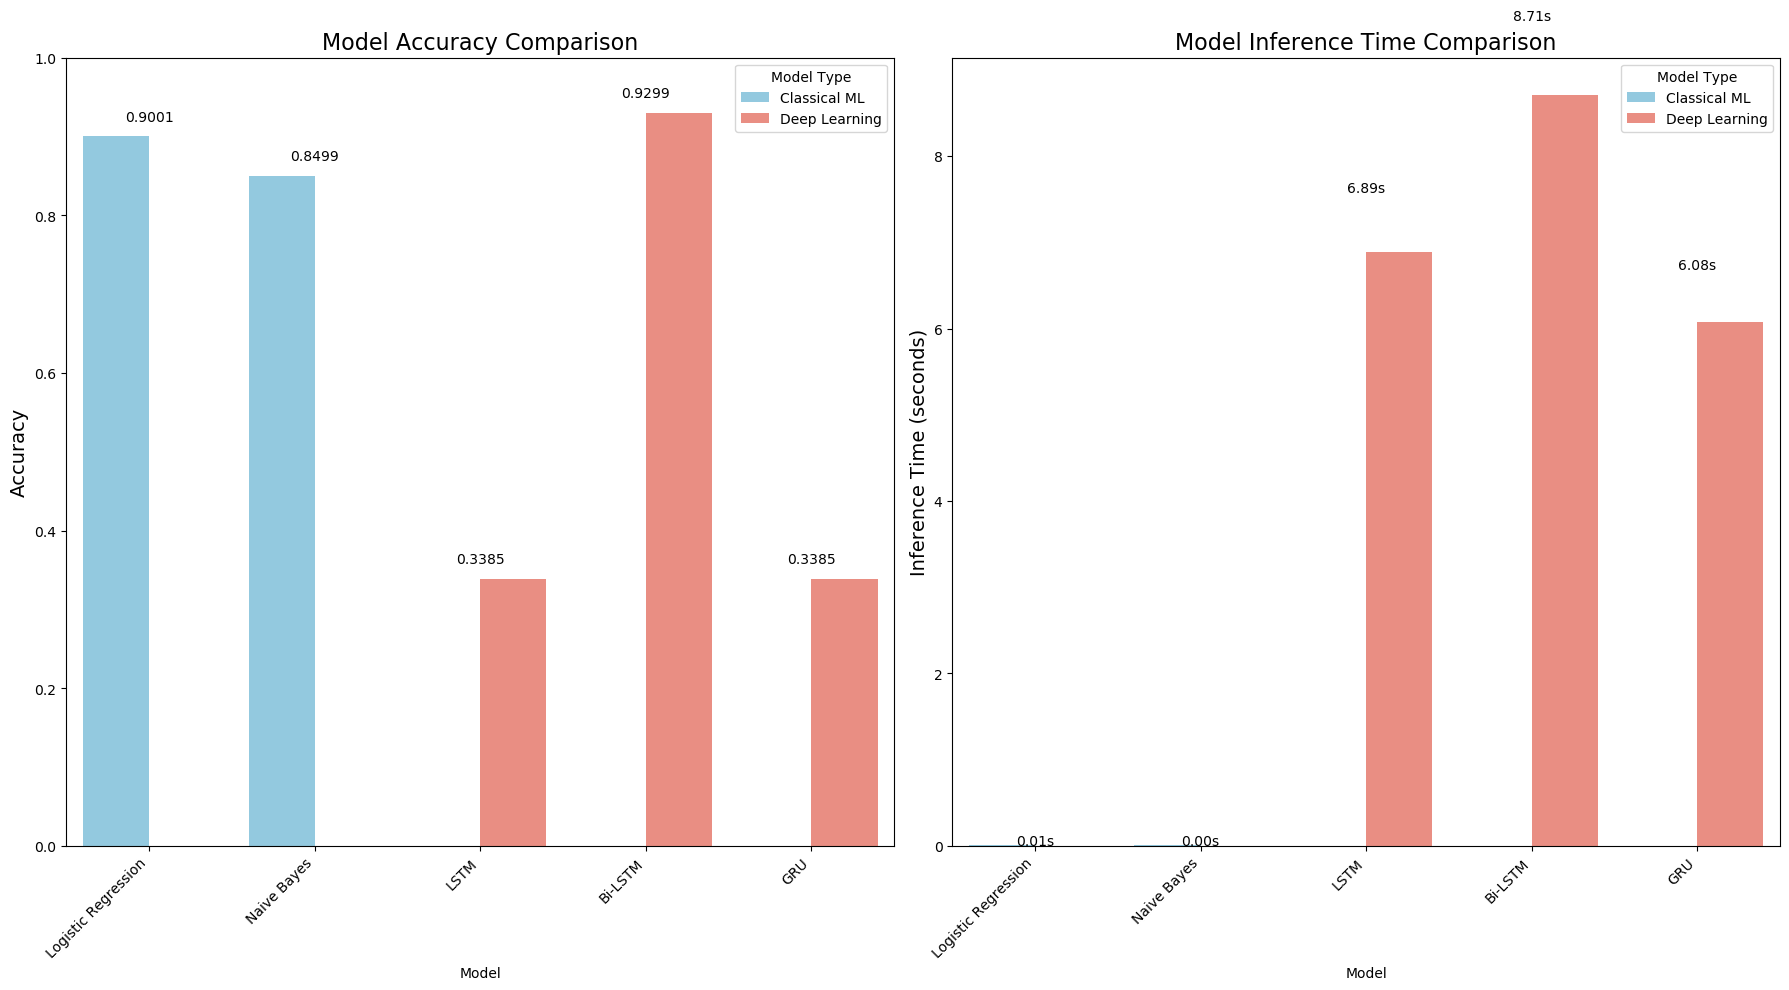

In [56]:
# Create plots to compare model performance
plt.figure(figsize=(18, 10))

# Plot 1: Accuracy comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=comparison_df, hue='Model Type', palette=['skyblue', 'salmon'])
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

# Plot 2: Inference Time comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Inference Time (s)', data=comparison_df, hue='Model Type', palette=['skyblue', 'salmon'])
plt.title('Model Inference Time Comparison', fontsize=16)
plt.ylabel('Inference Time (seconds)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
for i, v in enumerate(inference_times):
    plt.text(i, v * 1.1, f'{v:.2f}s', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

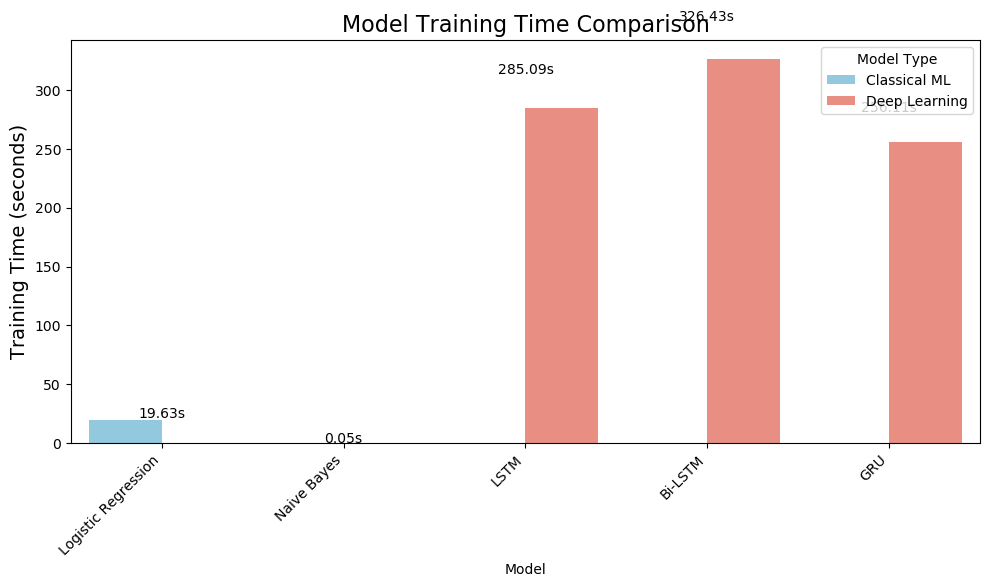

In [57]:
# Create a third plot for training time separately
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, hue='Model Type', palette=['skyblue', 'salmon'])
plt.title('Model Training Time Comparison', fontsize=16)
plt.ylabel('Training Time (seconds)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
for i, v in enumerate(training_times):
    plt.text(i, v * 1.1, f'{v:.2f}s', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

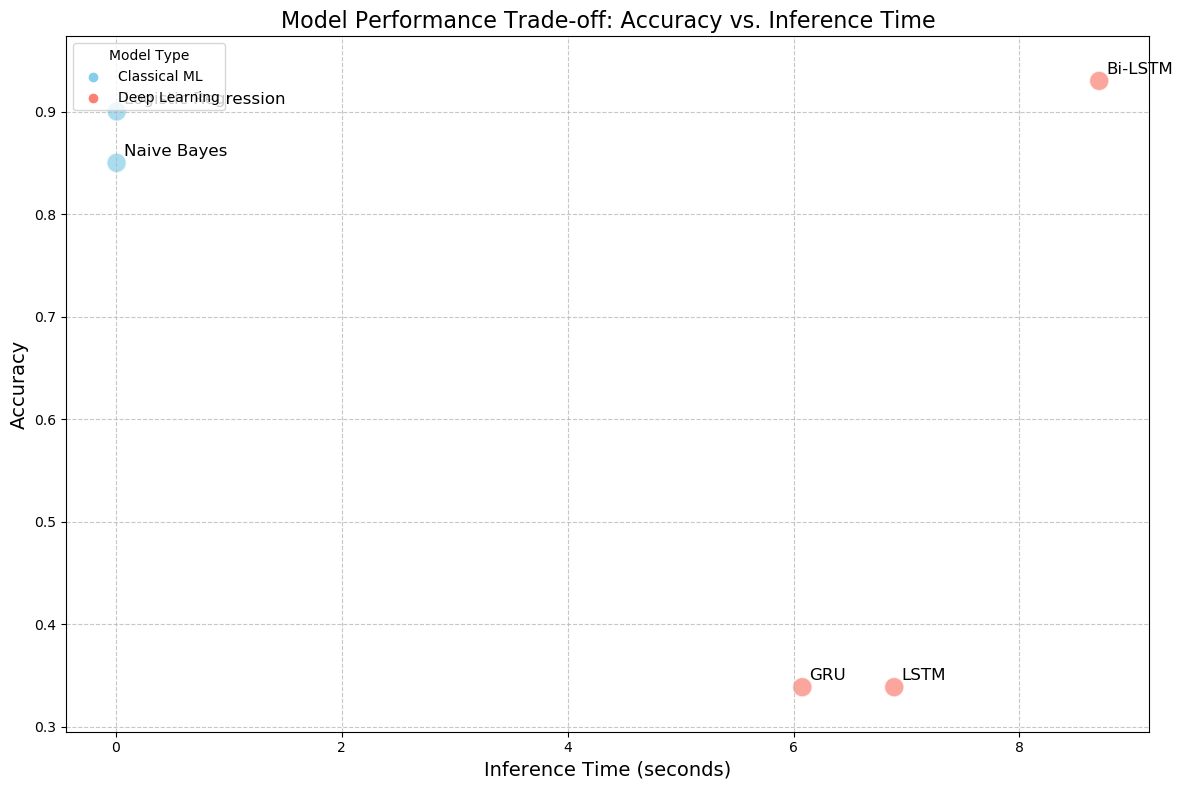

In [58]:
# Create a plot of accuracy vs. inference time (trade-off analysis)
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='Inference Time (s)', y='Accuracy', 
                         hue='Model Type', data=comparison_df, 
                         s=200, alpha=0.7, palette=['skyblue', 'salmon'])

# Add model name labels to each point
for i, model in enumerate(model_names):
    plt.annotate(model, 
                 (inference_times[i], accuracies[i]),
                 xytext=(5, 5), 
                 textcoords='offset points',
                 fontsize=12)

plt.title('Model Performance Trade-off: Accuracy vs. Inference Time', fontsize=16)
plt.xlabel('Inference Time (seconds)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Model Type')
plt.show()

In [59]:
# Display numerical comparison table with ranking
comparison_df['Accuracy Rank'] = comparison_df['Accuracy'].rank(ascending=False).astype(int)
comparison_df['Training Time Rank'] = comparison_df['Training Time (s)'].rank().astype(int)
comparison_df['Inference Time Rank'] = comparison_df['Inference Time (s)'].rank().astype(int)
comparison_df['Overall Rank'] = (comparison_df['Accuracy Rank'] + comparison_df['Inference Time Rank']).rank().astype(int)

print("\nModel Performance Rankings (lower is better):")
print(comparison_df.sort_values('Overall Rank')[['Model', 'Model Type', 'Accuracy', 'Inference Time (s)', 
                                                'Training Time (s)', 'Accuracy Rank', 
                                                'Inference Time Rank', 'Overall Rank']])


Model Performance Rankings (lower is better):
                 Model     Model Type  Accuracy  Inference Time (s)  \
0  Logistic Regression   Classical ML  0.900086            0.006636   
1          Naive Bayes   Classical ML  0.849932            0.004788   
3              Bi-LSTM  Deep Learning  0.929896            8.706280   
4                  GRU  Deep Learning  0.338452            6.077303   
2                 LSTM  Deep Learning  0.338452            6.891087   

   Training Time (s)  Accuracy Rank  Inference Time Rank  Overall Rank  
0          19.631386              2                    2             1  
1           0.048394              3                    1             1  
3         326.432151              1                    5             3  
4         256.108471              4                    3             4  
2         285.088539              4                    4             5  
